### Import the required libraries

In [1]:
from pathlib import Path
from typing import Iterator, Literal, Tuple, Union
from PIL import Image

from numpy.linalg import svd
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Specify the paths for the required files/folders

In [2]:
PROJECT_ROOT_DIR = Path().resolve()
DATA_DIR = PROJECT_ROOT_DIR / 'data'
DOG_FACES_DATASET_DIR = DATA_DIR / 'afhq_dog'
SMART_GRID_DATASET_PATH = DATA_DIR / 'dataset.csv'

# Question 1: PCA & Dogs

## Create utility functions to load, preprocess and stack the images

The explanation of the functions can be found in their docstrings.

In [3]:
def load_and_preprocess_image(image_path: Union[Path, str]) -> np.ndarray:
    """
    A utility function that does the following:
    1) load the image
    2) resize the image to (64, 64, 3) using bilinear resampling
    3) convert it to a numpy array with float64 dtype
    4) flatten the image to (4096 x 3)
    
    :param image_path: the filepath to the image
    """
    with Image.open(image_path) as im:
        im = im.resize((64, 64), resample=Image.Resampling.BILINEAR)
        im = np.asarray(im, dtype=np.float64)
        im = im.reshape((64 * 64, 3))
    return im

In [4]:
def stack_images(dataset_path: Union[Path, str]) -> Iterator[np.ndarray]:
    """
    A utility function to create an stack of images from a given directory
    using the load_and_preprocess_image function.
    
    :param dataset_path: the path to the folder containing the images
    """
    dataset_path = Path(dataset_path)
    return np.asarray([load_and_preprocess_image(filepath)
                       for filepath in dataset_path.iterdir()])

## Create utility functions to plot the images

The explanation of the functions can be found in their docstrings.

In [5]:
def plot_image(im: np.ndarray, title=None, cmap=None):
    """
    Plots an image preprocessed by the load_and_preprocess_image
    
    :param im: the image array with shape (4096, 3)
    """
    plt.figure()
    im = im.reshape((64, 64, -1))
    im = (im - im.min()) / (im.max() - im.min())
    if title:
        plt.title(title)
    plt.axis('off')
    plt.imshow(im, cmap=cmap)

In [6]:
def plot_channels(im: np.ndarray):
    """
    Plots the RGB channels of an image preprocessed
    by the load_and_preprocess_image in grayscale
    
    :param im: the image array with shape (4096, 3)
    """
    im = im.reshape((64, 64, -1))
    im = (im - im.min()) / (im.max() - im.min())

    fig, ax = plt.subplots(nrows=1, ncols=3)
    ax[0].set_axis_off()
    ax[1].set_axis_off()
    ax[2].set_axis_off()
    
    ax[0].title.set_text('R')
    ax[1].title.set_text('G')
    ax[2].title.set_text('B')
    
    ax[0].imshow(im[:, :, 0], cmap='gray')
    ax[1].imshow(im[:, :, 1], cmap='gray')
    ax[2].imshow(im[:, :, 2], cmap='gray')

**Load the data:**

In [7]:
X = stack_images(DOG_FACES_DATASET_DIR)

**We can now obtain the $i^{th}$ channel of $j^{th}$ image as $X[j, :, i]$**

In [8]:
X[0, :, 0].shape

(4096,)

**Plot the first image and its channels:**

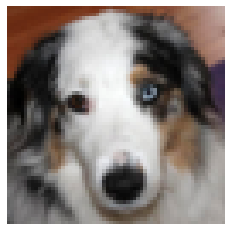

In [9]:
plot_image(X[0])

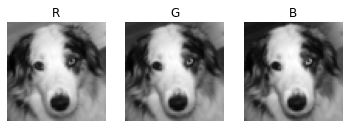

In [10]:
plot_channels(X[0])

## PCA Implementation

This class implements the PCA algorithm.

Detailed explanations of the methods can be found in the docstrings.

In [11]:
class PCA:
    def __init__(self):
        """
        Initializes the PCA class
        
        :param n_components: Number of components to keep.
        """
        self.mean = None
        self.U, self.S, self.Vt = None, None, None
        self._explained_variance = None
    
    @property
    def components(self) -> np.ndarray:
        """
        Returns the principle components of the given feature matrix.
        """
        return self.Vt
    
    @property
    def explained_variance(self):
        """
        Returns the explained variance by each principle component
        in decreasing order
        """
        return self._explained_variance
        
    @property
    def explained_variance_ratio(self):
        """
        Returns the explained variance ratio of each principle component
        in decreasing order.
        """
        return self.explained_variance / self.explained_variance.sum()
    
    @property
    def cumulative_explained_variance_ratio(self):
        """
        Returns the cumulative sum of the explained_variance_ratio.
        """
        return np.cumsum(self.explained_variance_ratio)
    
    @staticmethod
    def _sign_flip(U, Vt):
        """
        Sign flip for deterministic output.
        Ensures that the column with the largest absolute value in U is always positive.
        """
        max_abs = np.argmax(np.abs(U), axis=0)
        signs = np.sign(U[max_abs, range(U.shape[1])])
        U *= signs
        Vt *= signs[:, np.newaxis]
        return U, Vt
    
    def fit(self, X: Union[np.ndarray, pd.DataFrame]):
        """
        Fits the PCA class to a given data.
        Centralizes the data by substracting its mean
        and applies SVD to obtain the principle components.
        
        :param X: the matrix to which PCA algorithm will be applied. 
        """
        X = np.asarray(X).copy()
        mean = np.mean(X, axis=0, keepdims=True)
        U, S, Vt = svd(X - mean, full_matrices=False)
        U, Vt = self._sign_flip(U, Vt)
        
        self.mean = mean
        self.U, self.S, self.Vt = U, S, Vt
        self._explained_variance = self.S ** 2 / (len(X) - 1)
        return self
    
    def transform(self, X: Union[np.ndarray, pd.DataFrame], k: int = None):
        """
        Applies the dimensionality reduction to the given image using k principle components.
        
        :param X: the matrix to which dimensionality reduction will be applied.
        :param k: the number of principle components to be used for transformation
        """
        if k is None:
            components = self.components
        else:
            components = self.components[:k]
        return (X - self.mean) @ components.T
        
    def inverse_transform(self, X: Union[np.ndarray, pd.DataFrame], k: int = None):
        """
        Transforms the data back to its original space
        
        :param X: the matrix to which inverse transformation will be applied.
        :param k: the number of principle components to be used for transformation
        """
        if k is None:
            components = self.components
        else:
            components = self.components[:k]
        return X @ components + self.mean

**Fit the PCA class to the data:**

In [12]:
pca_R = PCA().fit(X[:, :, 0])
pca_G = PCA().fit(X[:, :, 1])
pca_B = PCA().fit(X[:, :, 2])

## Question 1.1

The explained variance ratios can be found by dividing the eigenvalues to the sum of the eigenvalues.

### Red Channel

**Proportion of variance explained:**

In [13]:
pca_R.explained_variance_ratio[:10]

array([0.21509283, 0.13543591, 0.07504976, 0.05173217, 0.04228943,
       0.02458328, 0.02177269, 0.01989858, 0.01707095, 0.0165596 ])

**The minimum number of principal components that are required to obtain at least 70% PVE:**

In [14]:
np.argwhere(pca_R.cumulative_explained_variance_ratio >= 0.7)[0, 0]

17

Here we can see that ~22% of the total variance is along the first principle component and we only need 17 of the principle components to recover more than 70% of the total variance.

### Green Channel

**Proportion of variance explained:**

In [15]:
pca_G.explained_variance_ratio[:10]

array([0.20045939, 0.13767809, 0.07695367, 0.05397123, 0.04291875,
       0.02602259, 0.02142653, 0.02081297, 0.01739352, 0.01681165])

**The minimum number of principal components that are required to obtain at least 70% PVE:**

In [16]:
np.argwhere(pca_G.cumulative_explained_variance_ratio >= 0.7)[0, 0]

18

Here we can see that ~20% of the total variance is along the first principle component and we only need 18 of the principle components to recover more than 70% of the total variance.

### Blue Channel

**Proportion of variance explained:**

In [17]:
pca_B.explained_variance_ratio[:10]

array([0.22997248, 0.1367852 , 0.07034023, 0.05356418, 0.03982173,
       0.02373238, 0.02099219, 0.02075867, 0.01668136, 0.01629307])

**The minimum number of principal components that are required to obtain at least 70% PVE:**

In [18]:
np.argwhere(pca_B.cumulative_explained_variance_ratio >= 0.7)[0, 0]

16

Here we can see that ~23% of the total variance is along the first principle component and we only need 16 of the principle components to recover more than 70% of the total variance.

## Question 1.2

### Red Channel

**Reshape first 10 principle components to (64, 64) and apply min-max scaling to obtain values between 0 and 1:**

In [19]:
components_R = pca_R.components[:10].reshape(10, 64, 64)
components_R = (components_R - components_R.min()) / (components_R.max() - components_R.min())

### Green Channel

**Reshape first 10 principle components to (64, 64) and apply min-max scaling to obtain values between 0 and 1:**

In [20]:
components_G = pca_G.components[:10].reshape(10, 64, 64)
components_G = (components_G - components_G.min()) / (components_G.max() - components_G.min())

### Blue Channel

**Reshape first 10 principle components to (64, 64) and apply min-max scaling to obtain values between 0 and 1:**

In [21]:
components_B = pca_B.components[:10].reshape(10, 64, 64)
components_B = (components_B - components_B.min()) / (components_B.max() - components_B.min())

### Obtain RGB images by stacking the color channels and plot

In [22]:
components = np.stack([components_R, components_G, components_B], axis=-1)

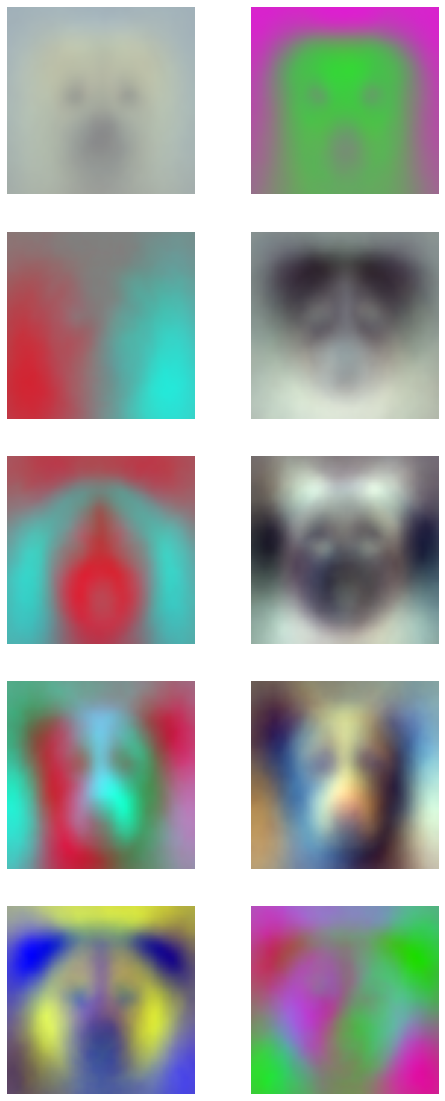

In [23]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(8, 20))
for index, component in enumerate(components):
    row, col = np.unravel_index(index, ax.shape)
    ax[row, col].set_axis_off()
    ax[row, col].imshow(component)

These images are the stacked principle components of the RGB channels, and a large proportion of the variance of original images is from these principle components. In other words, these images contain the most of the information contained by the original images. To be exact, the total explained variance ratio by the first 10 principle components for each channel are as follows:

In [24]:
pca_R.cumulative_explained_variance_ratio[10]

0.6335633768266342

In [25]:
pca_G.cumulative_explained_variance_ratio[10]

0.6287073108200758

In [26]:
pca_B.cumulative_explained_variance_ratio[10]

0.6431573999908139

## Question 1.3

**The principle components are found by substracting the mean from the image and multiplying them by the transpose of the first k principle components. The inversion can be done by multiplying the transformed image by the first k components and adding the mean. Note that since the principle components are orthonormal, the transpose of the matrix V containing the matrix is equal to the inverse of the matrix V.**

### Get the first image:

In [27]:
im = load_and_preprocess_image(DOG_FACES_DATASET_DIR / 'flickr_dog_000002.jpg')

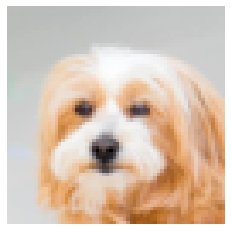

In [28]:
plot_image(im)

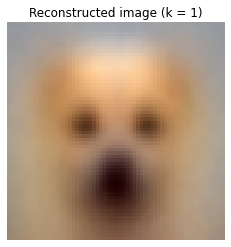

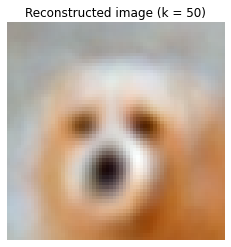

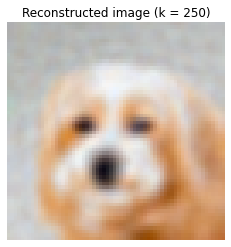

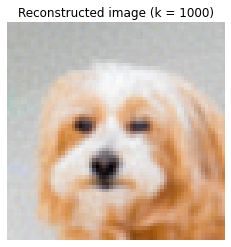

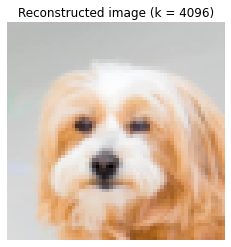

In [29]:
ks = [1, 50, 250, 1000, 4096]
pca_ = [pca_R, pca_G, pca_B]

for k in ks:
    tr_im = np.stack([pca.transform(im[..., i], k)[0]
                      for i, pca in enumerate(pca_)], axis=-1)
    rec_im = np.stack([pca.inverse_transform(tr_im[..., i], k)[0]
                                 for i, pca in enumerate(pca_)], axis=-1)
    
    plot_image(rec_im, title=f'Reconstructed image (k = {k})')

**We can observe that the reconstructed images becomes more similar to the original image as k increases. This is because the ratio of variance recovered increases with the number of principle components used for reconstruction.**

**Notice that for k = 4096, the reconstructed image is the same as original image:**

In [30]:
np.allclose(rec_im, im)

True

## Question 2: Logistic Regression

## Load the dataset

In [31]:
data = pd.read_csv(SMART_GRID_DATASET_PATH)

In [32]:
data.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,label
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,1
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0


## Split the dataset into train, validation and test datasets

In [33]:
X = data.drop('label', axis=1)
y = data['label']

In [34]:
n = len(y)

train_size = int(n * 0.7)
valid_size = int(n * 0.1)
test_size = int(n * 0.2)

X_train = X.iloc[:train_size]
y_train = y.iloc[:train_size]

X_valid = X.iloc[train_size: train_size + valid_size]
y_valid = y.iloc[train_size: train_size + valid_size]

X_test = X.iloc[train_size + valid_size:]
y_test = y.iloc[train_size + valid_size:]

In [35]:
print(X_train.shape, X_valid.shape, X_test.shape)

(42000, 12) (6000, 12) (12000, 12)


In [36]:
X_train.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923


## Scale the datasets

In [37]:
min_ = X_train.min(axis=0)
max_ = X_train.max(axis=0)

X_train = (X_train - min_) / (max_ - min_)
X_valid = (X_valid - min_) / (max_ - min_)
X_test = (X_test - min_) / (max_ - min_)

In [38]:
X_train.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4
0,0.258801,0.271561,0.829593,0.976938,0.509244,0.811604,0.495060,0.184582,0.632098,0.852199,0.881534,0.955842
1,0.926793,0.463424,0.268156,0.091499,0.813957,0.039926,0.084807,0.496648,0.382588,0.855185,0.539090,0.770281
2,0.891799,0.878795,0.268044,0.075200,0.425652,0.528354,0.481849,0.719673,0.118990,0.754416,0.831005,0.062977
3,0.022700,0.754704,0.419645,0.193735,0.556118,0.648349,0.040669,0.668416,0.417084,0.975538,0.925679,0.329163
4,0.277230,0.748301,0.467764,0.985024,0.453830,0.582974,0.102652,0.963811,0.786481,0.426780,0.638893,0.811508


## Implement the Logistic Regression model

In [39]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [40]:
def accuracy(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return np.mean(y_true == y_pred)

In [41]:
class LogisticRegression:
    """
    Logistic regression model that fits the parameters using gradient descent.

    Attributes:
        b : np.ndarray
            the bias vector of the model
        W : np.ndarray
            the weight matrix of the model
        alpha : float
            the learning rate of the model
    """
    def __init__(self, initializer: Literal['normal', 'uniform', 'zeros']):
        """
        The init method of the LogisticRegression model
        :param initializer: the weight initialization method
        """
        self._b = None
        self._W = None
        self.initializer = initializer
        self.check_initializer()

    @property
    def b(self) -> np.ndarray:
        """
        The y-intercept of the model
        :return: the y-intercept
        """
        return self._b

    @property
    def W(self) -> np.ndarray:
        """
        The weight matrix of the model
        :return: the weight matrix
        """
        return self._W

    def __repr__(self) -> str:
        """
        Returns the initialization signature of the instance
        :return: the string representation
        """
        return f'LogisticRegression(initializer={self.initializer})'

    def __str__(self) -> str:
        """
        Calls the repr method of the class
        :return: the string representation
        """
        return repr(self)
    
    def check_initializer(self):
        """
        Checks whether an initializer is implemented
        """
        return self.initializer in {'normal', 'uniform', 'zeros'}
    
    def initialize_parameters(self,
                              in_features: int,
                              initializer: Literal['normal', 'uniform', 'zeros'] = None):
        """
        Initializes the model parameters from a standart normal distribution
        
        :param in_features: the number of features
        """
        if initializer is None:
            initializer = self.initializer
        if initializer == 'zeros':
            self._b = 0
            self._W = np.zeros(in_features)
        else:
            rng = np.random.default_rng()
            if initializer == 'normal':
                self._b = rng.normal(0, 1, size=1)
                self._W = rng.normal(0, 1, size=in_features)
            elif initializer == 'uniform':
                self._b = rng.uniform(-0.01, 0.01, size=1)
                self._W = rng.uniform(-0.01, 0.01, size=in_features)
            else:
                raise NotImplementedError('Only "normal", "uniform" and '
                                          '"zeros" are supported as initializer.')

    def __call__(self, X: np.ndarray) -> np.ndarray:
        """
        Calculates the probability of being in the positive class
        :param X: the feature matrix
        :return: predictions
        """
        if self.b is None or self.W is None:
            raise RuntimeError('The model is not fit.')
        return sigmoid(self.b + X @ self.W)

    def fit(self,
            X: np.ndarray,
            y: np.ndarray,
            X_valid: np.ndarray,
            y_valid: np.ndarray,
            epochs: int = 1,
            batch_size: int = None,
            learning_rate: float = 0.01,
            shuffle: bool = True) -> np.ndarray:
        """
        Calculates the weights and bias of the model using the gradient descent algorithm
        :param X: the feature matrix
        :param y: the target vector
        :param epochs: the number of iterations over the training set
        :param batch_size: the batch size. Set to None to set batch size
                           equal to the train dataset size
        :param X_valid: the feature matrix of the validation dataset
        :param y_valid: the target vector of the validation dataset
        :return: the accuracy history
        """
        X = np.asarray(X)
        y = np.asarray(y)
        X_valid = np.asarray(X_valid)
        y_valid = np.asarray(y_valid)
        
        if self.b is None or self.W is None:
            self.initialize_parameters(X.shape[-1])

        if batch_size is None:
            batch_size = len(y)
        n_batches = len(y) // batch_size
        
        accuracy_ = accuracy(y_valid, self.predict(X_valid))
        history = [accuracy_]
        for epoch in tqdm(range(epochs)):
            indices = np.random.permutation(len(y_train)) if shuffle else np.arange(len(y_train))
            for batch in range(n_batches):
                batch_indices = indices[batch * batch_size: (batch + 1) * batch_size]
                X_batch = X[batch_indices]
                y_batch = y[batch_indices]

                grad_b, grad_W = self._calculate_gradients(X_batch, y_batch)
                self._b -= learning_rate * grad_b
                self._W -= learning_rate * grad_W
            accuracy_ = accuracy(y_valid, self.predict(X_valid))
            history.append(accuracy_)
        return np.asarray(history)

    def predict(self, 
                X: np.ndarray,
                threshold: float = 0.5) -> np.ndarray:
        """
        Predicts the class labels of the inputs
        
        :param X: the input data
        :param threshold: the threshold over which the class will be considered positive
        """
        return np.asarray(self(X) > threshold, dtype=np.int32)

    def _calculate_gradients(self,
                             X: np.ndarray,
                             y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        Calculate the gradients for binary crossentropy loss
        with current bias and weights
        :param X: the feature matrix
        :param y: the target vector
        :return: the gradients of the bias and the weights
        """
        y_pred = self(X)
        grad_b = np.mean(y_pred - y)
        grad_W = X.T @ (y_pred - y) / len(y)
        return grad_b, grad_W

**Note that the optimization problem for logistic regression is convex. Thus, for all of the following experiments, there is only one local minimum, which is the global minimum. Therefore, after sufficient number of iterations, the weights of all the models must converge to the same values for a sufficiently small the learning rate.**

## Question 2.1: Compare batch sizes

### Train the logistic regression model with batch size = 1

In [42]:
model_sgd = LogisticRegression(initializer='normal')
history_sgd = model_sgd.fit(X_train, y_train,
                            X_valid, y_valid,
                            epochs=500,
                            batch_size=1,
                            learning_rate=1e-3)

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [12:34<00:00,  1.51s/it]


### Train the logistic regression model with batch size = 64

In [43]:
model_mini_batch = LogisticRegression(initializer='normal')
history_mini_batch = model_mini_batch.fit(X_train, y_train,
                                          X_valid, y_valid,
                                          epochs=500,
                                          batch_size=64,
                                          learning_rate=1e-3)

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:16<00:00, 29.49it/s]


### Train the logistic regression model with batch size = dataset size

In [44]:
model_full_batch = LogisticRegression(initializer='normal')
history_full_batch = model_full_batch.fit(X_train, y_train,
                                          X_valid, y_valid,
                                          epochs=500,
                                          batch_size=None,
                                          learning_rate=1e-3)

100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 281.13it/s]


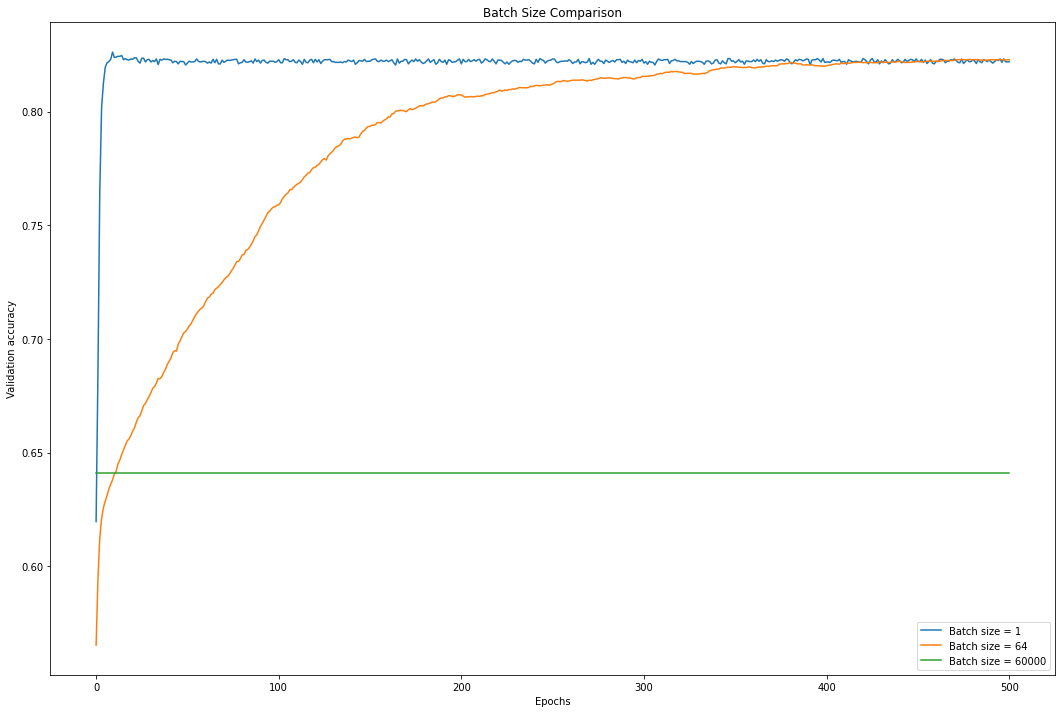

In [45]:
x = list(range(500 + 1))

plt.figure(figsize=(18, 12))
plt.title('Batch Size Comparison')
plt.xlabel('Epochs')
plt.ylabel('Validation accuracy')
plt.plot(x, history_sgd, label='Batch size = 1')
plt.plot(x, history_mini_batch, label='Batch size = 64')
plt.plot(x, history_full_batch, label=f'Batch size = {n}')
plt.legend()
plt.show()

**We can observe that training with full batches takes so many epochs to converge compared to the other batch sizes whereas the model trained with batches of single instances converges in the least number of epochs. However, as we can see in the progress bars, each epoch takes much more time compared to the mini batch with size 64. Also, the training is more stable when batch size is 64 as we can deduce from the oscillations of the plots. Therefore, for this task, mini batches with size 64 seems to be the most convenient one among these three options.**

## Question 2.2: Compare initialization techniques

### Train the logistic regression model with weights $w \sim \mathcal{N(0, 1)}$

In [46]:
model_normal = LogisticRegression(initializer='normal')
history_normal = model_normal.fit(X_train, y_train,
                                  X_valid, y_valid,
                                  epochs=500,
                                  batch_size=64,
                                  learning_rate=1e-4)

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:16<00:00, 29.59it/s]


### Train the logistic regression model with weights $w \sim \mathcal{U(0.01, 0.01)}$

In [47]:
model_uniform = LogisticRegression(initializer='uniform')
history_uniform = model_uniform.fit(X_train, y_train,
                                    X_valid, y_valid,
                                    epochs=500,
                                    batch_size=64,
                                    learning_rate=1e-4)

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:16<00:00, 30.00it/s]


### Train the logistic regression model with weights $w = 0$

In [48]:
model_zeros = LogisticRegression(initializer='zeros')
history_zeros = model_zeros.fit(X_train, y_train,
                                X_valid, y_valid,
                                epochs=500,
                                batch_size=64,
                                learning_rate=1e-4)

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:14<00:00, 33.79it/s]


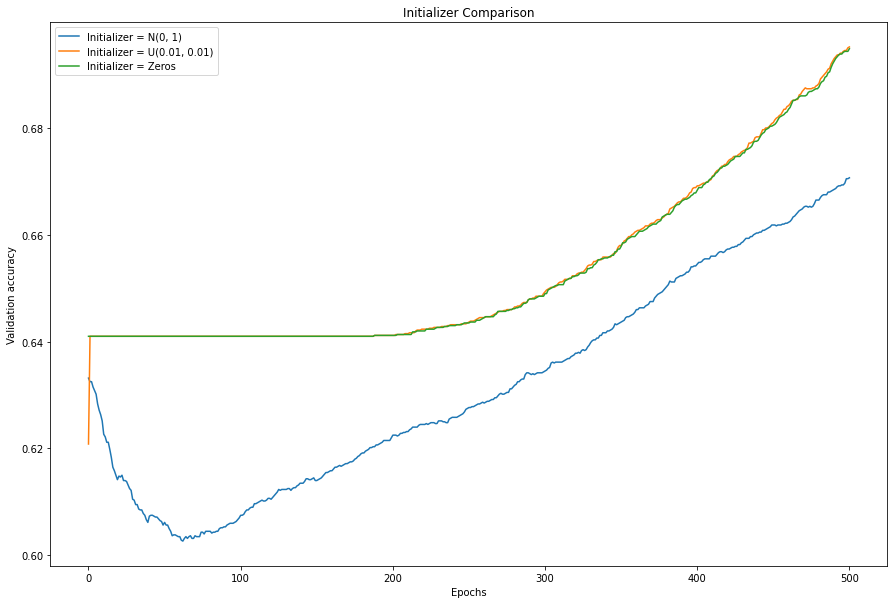

In [49]:
x = list(range(500 + 1))

plt.figure(figsize=(15, 10))
plt.title('Initializer Comparison')
plt.xlabel('Epochs')
plt.ylabel('Validation accuracy')
plt.plot(x, history_normal, label='Initializer = N(0, 1)')
plt.plot(x, history_uniform, label='Initializer = U(0.01, 0.01)')
plt.plot(x, history_zeros, label=f'Initializer = Zeros')
plt.legend()
plt.show()

**We can observe that the weights initialized using a standard normal distribution leads to slower convergence among these three initialization techniques whereas zero initialization and uniform initialization perform similar to each other. Between these two options, zero initialization will be prefered to reduce stochasticity caused by the initialization.**

## Question 2.3: Compare learning rates

### Train the logistic regression model with learning rate $\alpha = 10^{-3}$

In [50]:
model_3 = LogisticRegression(initializer='normal')
history_3 = model_3.fit(X_train, y_train,
                        X_valid, y_valid,
                        epochs=500,
                        batch_size=64,
                        learning_rate=1e-3)

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:49<00:00, 10.09it/s]


### Train the logistic regression model with learning rate $\alpha = 10^{-4}$

In [51]:
model_4 = LogisticRegression(initializer='normal')
history_4 = model_4.fit(X_train, y_train,
                        X_valid, y_valid,
                        epochs=500,
                        batch_size=64,
                        learning_rate=1e-4)

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:49<00:00, 10.10it/s]


### Train the logistic regression model with learning rate $\alpha = 10^{-5}$

In [52]:
model_5 = LogisticRegression(initializer='normal')
history_5 = model_5.fit(X_train, y_train,
                        X_valid, y_valid,
                        epochs=500,
                        batch_size=64,
                        learning_rate=1e-5)

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [19:55<00:00,  2.39s/it]


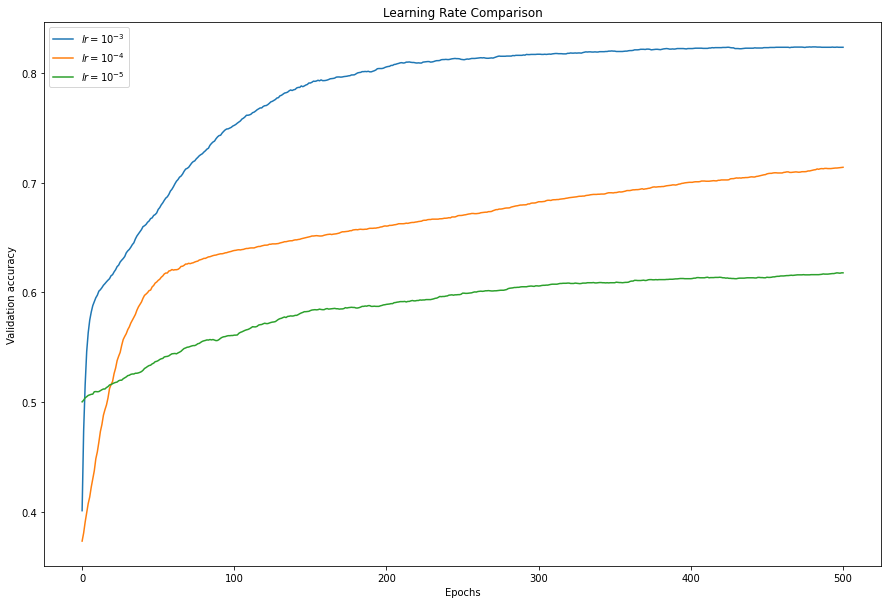

In [53]:
x = list(range(500 + 1))

plt.figure(figsize=(15, 10))
plt.title('Learning Rate Comparison')
plt.xlabel('Epochs')
plt.ylabel('Validation accuracy')
plt.plot(x, history_3, label='$lr = 10^{-3}$')
plt.plot(x, history_4, label='$lr = 10^{-4}$')
plt.plot(x, history_5, label='$lr = 10^{-5}$')
plt.legend()
plt.show()

**We can observe that the $\alpha = 10^{-3}$ leads to faster convergence among these three options. However, for $\alpha = 10^{-4}$ and $\alpha = 10^{-5}$, the weights converge so slow.**

## Train the optimal model with the best set of hyperparameters

**During the experiments, we observed that the best hyperparameters for this task is as follows:**

**1) Batch size: 64**

**2) Initizaliter: Zeros**

**3) Learning rate: $10^{-3}$**

In [54]:
best_model = LogisticRegression(initializer='zeros')
history_best_model = best_model.fit(X_train, y_train,
                                    X_valid, y_valid,
                                    epochs=500,
                                    batch_size=64,
                                    learning_rate=1e-3)

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [16:27<00:00,  1.98s/it]


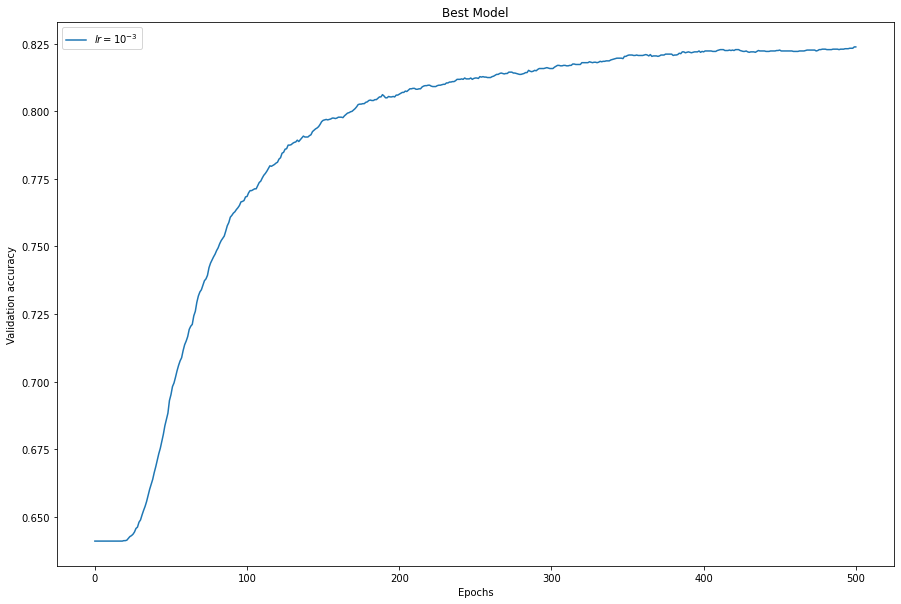

In [55]:
x = list(range(500 + 1))

plt.figure(figsize=(15, 10))
plt.title('Best Model')
plt.xlabel('Epochs')
plt.ylabel('Validation accuracy')
plt.plot(x, history_best_model, label='$lr = 10^{-3}$')
plt.legend()
plt.show()

## Calculate metrics on test set

In [56]:
def create_confusion_matrix(y_pred: np.ndarray,
                            y_true: np.ndarray) -> np.ndarray:
    """
    Creates the confusion matrix given the true labels and predictions
    
    :param y_pred: the predicted labels
    :param y_true: the true labels
    """
    cm = np.zeros((2, 2))
    for pred, true in zip(y_pred, y_true):
        cm[(1 - pred), (1 - true)] += 1
    return cm

In [57]:
def f_beta_score(precision: float, recall: float, beta: float = 1) -> float:
    """
    Calculates f_beta score using precision and recall
    
    :param precision: the precision value
    :param recall: the recall value
    """
    beta_sq = beta ** 2
    return (1 + beta_sq) * precision * recall / (beta_sq * precision + recall)

In [58]:
def calculate_metrics(cm: np.ndarray):
    """
    Calculates accuracy, precision, recall,
    F1-score, F2-score, F0.5-score, and false positive rate
    given a confusion matrix
    """
    precision = cm[0, 0] / np.sum(cm[0])
    recall = cm[0, 0] / np.sum(cm[:, 0])
    return {
        'accuracy': (cm[0, 0] + cm[1, 1]) / np.sum(cm),
        'precision': precision,
        'recall': recall,
        'f1_score': f_beta_score(precision, recall, beta=1),
        'f2_score': f_beta_score(precision, recall, beta=2),
        'f0.5_score': f_beta_score(precision, recall, beta=0.5),
        'false_positive_rate': cm[0, 1] / np.sum(cm[:, 1])
    }

**Predict the test labels:**

In [59]:
y_test_pred = best_model.predict(X_test)

## Report the confusion matrix

In [60]:
cm = create_confusion_matrix(y_test_pred, y_test)

In [61]:
print(cm)

[[2853.  762.]
 [1496. 6889.]]


## Report the metrics

In [62]:
metrics = calculate_metrics(cm)

In [63]:
metrics

{'accuracy': 0.8118333333333333,
 'precision': 0.7892116182572614,
 'recall': 0.6560128765233387,
 'f1_score': 0.7164741336012054,
 'f2_score': 0.6789300842415877,
 'f0.5_score': 0.758413525439949,
 'false_positive_rate': 0.09959482420598614}

For this task, it is more important to detect the unstable grids than to detecting with high precision since undetected unstable grid might cause harmful effects whereas a mistaken warning only causes some time to check the power grid. Thus, detecting positives are more important than detecting negatives. Therefore, recall metric is more important than precision since the recall metrics measures the ratio of detected positives to all positives. Similarly, $f_{2}$-score is more important than $f_{1}$-score and $f_{0.5}$-score since higher beta values give more importance to recall.